In [1]:
import sys
sys.path.insert(0, "/home/jogi/git/repository/meta_learner")
if "/home/jogi/.local/lib/python2.7/site-packages" in sys.path:
    sys.path.remove("/home/jogi/.local/lib/python2.7/site-packages")

import matplotlib
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

from datetime import datetime
from pytz import timezone
import itertools
import copy

import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
from collections import OrderedDict


from utils.experiment import Experiment
from utils.common import get_model, create_def_argparser, create_logger, softmax
from utils.plots import loss_plot, param_error_plot, plot_qt_probs, plot_dist_optimization_steps
from utils.plots import plot_actsb_qts, plot_image_map_data, plot_image_map_losses
from utils.plots import plot_loss_over_tsteps, plot_halting_step_stats_with_loss, plot_loss_versus_halting_step
from utils.probs import TimeStepsDist, ConditionalTimeStepDist
from utils.config import config
from val_optimizer import validate_optimizer
from utils.regression import RegressionFunction, L2LQuadratic, RegressionWithStudentT
from utils.helper import tensor_and, tensor_any
from utils.batch_handler import ACTBatchHandler
from utils.epoch import Epoch, halting_step_stats
from models.rnn_optimizer import MetaLearner, AdaptiveMetaLearnerV1, AdaptiveMetaLearnerV2
from models.sb_act_optimizer import StickBreakingACTBaseModel

from utils.regression import RegressionFunction, L2LQuadratic, neg_log_likelihood_loss, RosenBrock
from utils.regression import RegressionWithStudentT

%load_ext autoreload
%autoreload 2

In [2]:
expers_to_load = [# Meta V1 model regression
                  (True, "run_20170828_11_40_34_metaV1_30ep_50ops_lr5e05"), # 50ops
                  (False, "run_20170814_17_04_25_metaV1_50ep_100ops_lr3e05"), # 100ops
                  (False, "run_20170814_12_03_15_metaV2_50ep_26ops_lr3e05"), # stochastic 26 ops
                  # Stick-breaking V1 model
                  (False, "run_20170828_12_02_15_act_sbV1_30ep_nu0.9_lr5e05"), # nu=0.90, tau=0.05
                  (False, "run_20170828_14_02_23_act_sbV1_30ep_nu0.9_lr5e05"), # nu=0.9 but without adding remainder to all last steps
                  (False, "run_20170828_14_35_41_act_sbV1_30ep_nu0.9_lr5e05"), # nu=0.9 original WITHOUT MEAN FIELD (but with remainder which is never reached)
                  (True, "run_20170828_17_39_05_act_sbV3.1_30ep_nu0.9_lr5e05"),  # with extra penalty
                  (False, "run_20170828_15_17_36_act_sbV1_30ep_nu0.9_lr5e05"), # without extra penalty
                  # Graves ACT model
                  (False, "run_20170821_10_37_18_act_sbV2_50ep_nu0.9_lr5e05"), # with cost annealing until 1.
                  (False, "run_20170821_10_51_40_act_sbV2_50ep_nu0.9_lr5e05")] # with cost annealing unitl 0.5



In [3]:
## IMPORTANT ---- NUMBER OF STEPS FOR TEST EVALUATION
MAX_EVAL_STEPS = 200

without_models = False

experiments = []
models = []
new_experiments = []
explogger = None
m = 0
if 'logger' in vars() or 'logger' in globals():
    pass
else:
    logger = create_logger(exper=None, file_handler=True, output_dir="/home/jogi/git/repository/meta_learner/logs")

for e, exp_path in enumerate(expers_to_load):
    if exp_path[0]:
        
        exp = Experiment.load(exp_path[1], do_log=True, meta_logger=logger)
            
        if "act" in exp.args.model:
            print("{} Loading model {} (q-prob {:.2f}) / {}".format(m, exp.args.model, 
                                                                    exp.config.ptT_shape_param,
                                                                    exp.args.log_dir))
        else:
            print("{} Loading model {} / {}".format(m, exp.args.model, exp.args.log_dir))
        
        experiments.append(exp)
        m += 1
        if not without_models:
            models.append(get_model(exp, exp.args.x_dim, retrain=True))
        new_experiments.append(Experiment(exp.args, exp.config))
        new_experiments[-1].batch_handler_class = experiments[-1].batch_handler_class
        new_experiments[-1].output_dir = experiments[-1].output_dir
        new_experiments[-1].reset_val_stats()
        new_experiments[-1].meta_logger = logger


INFO - created local logger for experiment with model metaV1_regression_50ops
INFO - INFO - loaded existing model from file logs/run_20170828_11_40_34_metaV1_30ep_50ops_lr5e05/metaV1_regression_50ops.pkl
INFO - Note: MetaLearner is running on GPU
INFO - ['linear1.weight', 'linear1.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.fc_h2h.bias', 'linear_out.weight']
INFO - created local logger for experiment with model act_sbV3.1_regression_nu0.9
INFO - INFO - loaded existing model from file logs/run_20170828_17_39_05_act_sbV3.1_30ep_nu0.9_lr5e05/act_sbV3.1_regression_nu0.9.pkl
INFO - Note: StickBreakingACTBaseModel is running on GPU
INFO - ['linear_in.weight', 'linear_in.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.f

0 Loading model metaV1_regression_50ops / run_20170828_11_40_34_metaV1_30ep_50ops_lr5e05
1 Loading model act_sbV3.1_regression_nu0.9 (q-prob 0.90) / run_20170828_17_39_05_act_sbV3.1_30ep_nu0.9_lr5e05


In [6]:
del new_experiments
new_experiments = []


for exper in expers_to_load:
    if exper[0]:
        print("Loading experiment {}".format(exper[1]))
        new_experiments.append(Experiment.load(path_to_exp=exper[1] + "/" + 
                                               "exp_eval_stats_10000_" + str(MAX_EVAL_STEPS) +"steps.dll",
                                               full_path=True))
        if new_experiments[-1].meta_logger is None:
            new_experiments[-1].meta_logger = logger
print("Ready")

Loading experiment run_20170828_11_40_34_metaV1_30ep_50ops_lr5e05
Loading experiment run_20170828_17_39_05_act_sbV3.1_30ep_nu0.9_lr5e05
Ready


In [4]:
with open("data/test_regression_10000_10_1.0_10.dll", 'rb') as f:
     test_funcs = dill.load(f)
print("Ready")

Ready


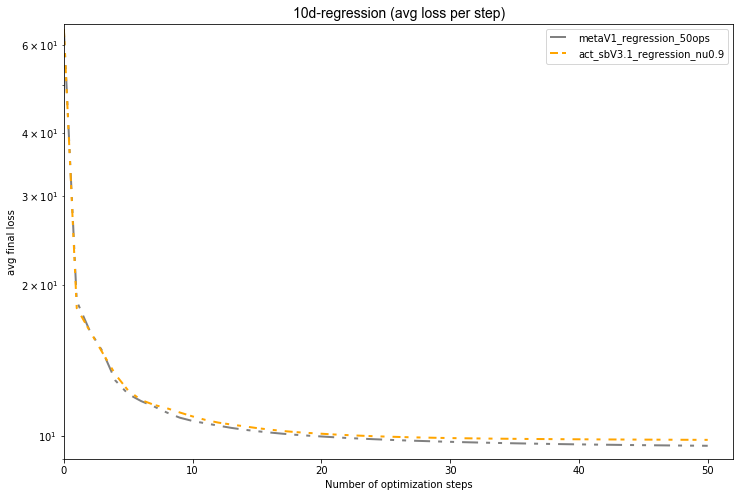

In [7]:
# new_exp_select = [new_experiments[3], new_experiments[4], new_experiments[7]] #, new_experiments[4]] 
best_val_runs, lowest_value = plot_loss_over_tsteps(new_experiments, do_show=True, 
                                              do_save=False, 
                                              plot_best=False,
                                              fig_name="10reg_actsb_compare_metaV1V2_actsb93_50_500", 
                                              loss_type="loss",
                                              min_step=0,
                                              max_step=50,
                                              sort_exper="10d-regression",
                                              log_scale=True,
                                              y_lim=[9, 66],
                                              with_stddev=False,
                                              runID=None)

INFO - Successfully saved fig logs/run_20170814_19_02_30_act_sbV1_50ep_nu0.9_lr5e05/loss_optimizer_act_sbV1_50ep_nu0.9_08:58:01.png


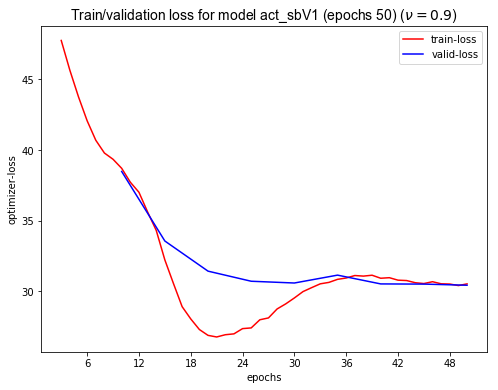

In [5]:
loss_plot(experiments[1], loss_type="opt_loss", save=True, show=True, 
          log_scale=False, validation=True, only_val=False)

In [ ]:
# exp_error_curves = [experiments[0],  experiments[3]]
for exp, mdl in zip(experiments, models):
    print(mdl.name)
    loss_plot(exp, loss_type="loss", save=False, validation=True, show=True)


In [ ]:
# eval_new_val_expers = [new_experiments[0], new_experiments[3]] #, new_experiments[5]]

best_val_runs, lowest_value = plot_val_result(new_experiments, 
                                              do_show=True, 
                                              do_save=True, 
                                              plot_best=False,
                                              loss_type="loss",
                                              fig_name="expv5_val_results_1000_loss_10ops")

In [ ]:
# eval_expers = new_exp_only = [experiments[0], experiments[1], experiments[2]]
plot_parm_loss_steps(experiments, num_of_plots=4, do_show=True, 
                     do_save=False, loss_type="loss", log_scale=False, max_step=20,
                    fig_name="metaV2_val_loss_during_training")

In [5]:
exp_idx = 1
model = models[exp_idx]

max_steps = 200
# new_experiments[exp_idx].model_path

new_experiments[exp_idx].epoch = 400
new_experiments[exp_idx].config.max_val_opt_steps = max_steps
new_experiments[exp_idx].config.T = max_steps
new_experiments[exp_idx].type_prior = "geometric"


epoch_obj = Epoch()
epoch_obj.start(new_experiments[exp_idx])
print("Validating model {} with q-prob {:.3f}".format(model.name, experiments[exp_idx].config.ptT_shape_param))
new_experiments[exp_idx].eval(epoch_obj, model, functions=test_funcs, save_run=None, save_model=False)
print("End....")
new_experiments[exp_idx].save("exp_eval_stats_10000_"+str(max_steps) + "steps.dll")

INFO - Epoch: 400 - Evaluating 10000 test functions


Validating model act_sbV3.1_regression_nu0.9 with q-prob 0.900


INFO - ! - Validation last step 200 - !
INFO - Epoch: 400 - evaluation result - time step losses
INFO - [ 64.415  17.951  16.189  14.633  13.248  12.301  11.783  11.523  11.346
  11.128  10.928  10.754  10.622  10.531  10.445  10.359  10.288  10.224
  10.171  10.132  10.096  10.061  10.033  10.006   9.982   9.964   9.947
   9.931   9.919   9.908   9.896   9.888   9.881   9.873   9.868   9.862
   9.857   9.853   9.849   9.844   9.841   9.838   9.835   9.832   9.83
   9.827   9.825   9.822   9.82    9.818   9.816   9.813   9.812   9.81
   9.807   9.806   9.804   9.802   9.8     9.798   9.796   9.795   9.793
   9.791   9.79    9.788   9.787   9.785   9.784   9.782   9.781   9.779
   9.777   9.776   9.775   9.773   9.772   9.771   9.769   9.768   9.766
   9.765   9.764   9.762   9.761   9.76    9.758   9.757   9.756   9.754
   9.753   9.752   9.751   9.749   9.748   9.747   9.746   9.745   9.743
   9.742   9.741   9.74    9.738   9.738   9.736   9.735   9.734   9.733
   9.732   9.731   9.7

End....


In [9]:
X = np.vstack(new_experiments[2].val_stats["halt_step_funcs"].values())

In [6]:

exp_idx = 0
max_steps = MAX_EVAL_STEPS
new_experiments[exp_idx].epoch = 400
new_experiments[exp_idx].config.max_val_opt_steps = max_steps
new_experiments[exp_idx].config.T = max_steps
new_experiments[exp_idx].config.qt_threshold = 0.95
new_experiments[exp_idx].reset_val_stats()
if new_experiments[exp_idx].meta_logger is None:
    new_experiments[exp_idx].meta_logger = logger
# the same object for the validation data
model = models[exp_idx]
model.opt_step_hist_val = np.zeros(new_experiments[exp_idx].config.max_val_opt_steps)
model.qt_hist_val = OrderedDict([(i, np.zeros(i)) 
                                 for i in np.arange(1, new_experiments[exp_idx].config.max_val_opt_steps + 1)])
print("Validating model {} with q-prob {:.3f}".format(model.name, experiments[exp_idx].config.ptT_shape_param))

if "act" in model.name:
    model.init_qt_statistics(new_experiments[exp_idx].config)

validate_optimizer(model, new_experiments[exp_idx], explogger, val_set=test_funcs, 
                   max_steps=max_steps, verbose=False, plot_func=False, show_plot=False, save_plot=False,
                   num_of_plots=5, save_model=False, save_qt_prob_funcs=False, 
                   save_run="exp_eval_stats_10000_"+str(max_steps) + "steps")
new_experiments[exp_idx].save("exp_eval_stats_10000_"+str(max_steps) + "steps.dll")

INFO - ---------------------------------------------------------------------------------------
INFO - INFO - Epoch 400: Validating model metaV1_regression_50ops with 10000 functions


Validating model metaV1_regression_50ops with q-prob 0.950


INFO - INFO - Epoch 400, elapsed time 8.01 seconds: 
INFO - INFO - Epoch 400: Final validation stats: total-step-losses / final-step loss / final-true_min: 2.004e+03/9.407/0.2173
INFO - INFO - Epoch 400: Final step losses: [ 64.415  18.537  16.202  14.727  12.883  12.106  11.724  11.437  11.124
  10.866  10.702  10.588  10.476  10.37   10.283  10.213  10.151  10.095
  10.047  10.006   9.969   9.934   9.901   9.873   9.847   9.823   9.8
   9.78    9.762   9.744   9.728   9.713   9.699   9.686   9.674   9.662
   9.652   9.642   9.632   9.623   9.615   9.607   9.6     9.593   9.586
   9.58    9.574   9.568   9.563   9.558   9.553   9.549   9.544   9.54
   9.536   9.532   9.528   9.525   9.522   9.519   9.516   9.513   9.51
   9.508   9.505   9.503   9.5     9.498   9.496   9.495   9.492   9.49
   9.489   9.486   9.485   9.483   9.482   9.48    9.479   9.477   9.476
   9.475   9.473   9.472   9.47    9.47    9.468   9.467   9.466   9.464
   9.464   9.462   9.461   9.46    9.459   9.458   9

In [ ]:
plot_qt_probs(new_experiments[2], data_set="val", save=True, show=True, 
              plot_prior=False, height=20, width=20, add_info=True)

In [ ]:
from utils.plots import create_exper_label
num_of_plots = 13
T0 = 23
fig = plt.figure(figsize=(8, 25))

for i in range(1, num_of_plots+1):
    T = T0+i
    index = np.arange(1, T+1).astype(int)
    qt = exper.val_stats["qt_hist"][30][T]
    ax1 = plt.subplot(num_of_plots, 1, i)
    plt.bar(index, qt, 0.3, label="q(t|{})".format(T))
    ax1.legend(loc="best")
    
fig_name = "_" + "val" + "_" + create_exper_label(exper)
fig_name = os.path.join(exper.output_dir, config.qt_dist_prefix + fig_name + ".png")
plt.savefig(fig_name, bbox_inches='tight')
plt.close()

INFO - Successfully saved fig logs/run_20170814_17_04_25_metaV1_50ep_100ops_lr3e05/loss_metaV1_50ep_100ops_21:43:29.png


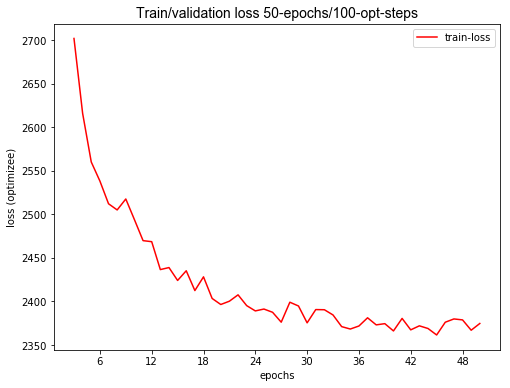

In [41]:
loss_plot(experiments[0], show=True, save=True, validation=False, only_val=False)

In [ ]:
plot_actsb_qts(new_experiments[3], data_set="eval", save=False, show=True, add_info=False, epoch=400, 
              fig_name="qt_dist_test_eval_500steps")

INFO - Successfully saved fig logs/run_20170815_14_33_06_act_sbV2_50ep_nu0.95_lr5e05/T_dist_eval.png


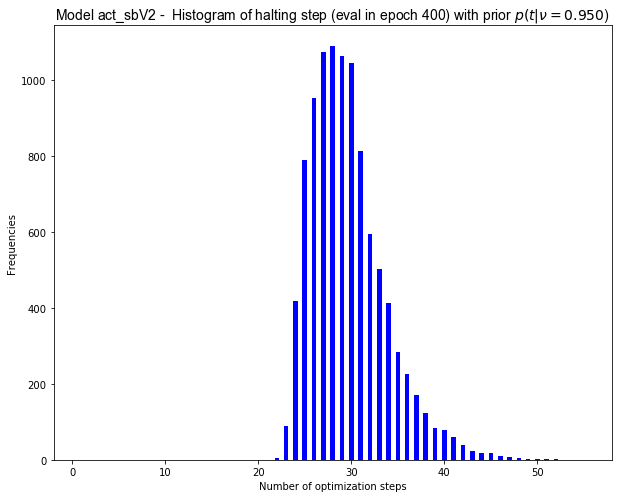

In [79]:
plot_dist_optimization_steps(new_experiments[2], data_set="eval", save=True, show=True, epoch=400)

INFO - Successfully saved fig logs/run_20170828_17_39_05_act_sbV3.1_30ep_nu0.9_lr5e05/halting_step_versus_nll_distance.png


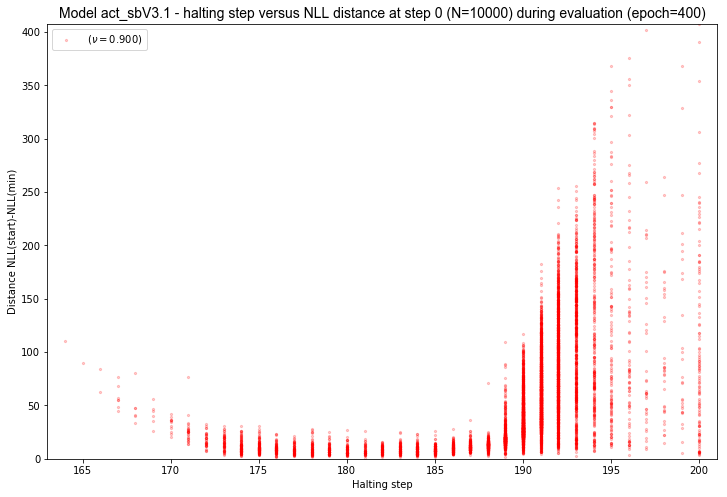

In [8]:
plot_loss_versus_halting_step(new_experiments[1], epoch=400, do_show=True, do_save=True)

In [47]:
new_experiments[3].val_stats["halt_step_funcs"][400]

array([ 41.,  51.,  36., ...,  51.,  58.,  45.], dtype=float32)

In [ ]:
def compute_yt(W, x):
    return torch.transpose(torch.mm(W ,x.unsqueeze(1)), 1,0)

def compute_params(W, y, cuda=False):
    
    A_plus = np.linalg.pinv(W.data.cpu().numpy())
    y = y.data.cpu().numpy()
    params = np.squeeze(np.dot(A_plus, y))
    params = Variable(torch.from_numpy(params).float().unsqueeze(0))
    if cuda:
        params = params.cuda()
    return params
    


In [ ]:
plot_qt_detailed_stats(new_experiments[0], test_funcs, do_save=True, do_show=True, threshold=0.90)

In [ ]:
 # 
plot_kl_div_parts(new_experiments[1], save=False, show=True, final_terms=False, log_qt=True, plot_prior=True,
                 fig_name="kl_parts_without_tanh")

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection='3d')

s = 0.05   # Try s=1, 0.25, 0.1, or 0.05
X = np.arange(-1.2, 4+s, s)   #Could use linspace instead if dividing
Y = np.arange(10, 13+s, s)   #evenly instead of stepping...
    
#Create the mesh grid(s) for all X/Y combos.
X, Y = np.meshgrid(X, Y)

#Rosenbrock function w/ two parameters using numpy Arrays
Z = (3.5-X)**2 + 100.*(Y-X*X)**2

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
         linewidth=0, antialiased=False)  #Try coolwarm vs jet

plt.xlabel('x')
plt.ylabel('y')
# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

#Displays the figure, handles user interface, returns when user closes window
plt.show()

In [5]:
"""
    Generate new test functions
"""
test_funcs = RegressionWithStudentT(n_funcs=10000, n_samples=10, x_dim=10, scale_p=1., shape_p=1, use_cuda=True)
with open("data/test_regression_T_10000_10_1.0_10.dll", 'wb') as f:
     dill.dump(test_funcs, f)
print("Ready")


Ready


In [5]:
funcs = RegressionFunction(n_funcs=10, n_samples=10, stddev=1., x_dim=5, use_cuda=True, 
                                calc_true_params=False)
print(funcs.true_minimum_nll)

Variable containing:
 9.1894
[torch.cuda.FloatTensor of size 1 (GPU 0)]



In [3]:
test_funcs = RegressionFunction(n_funcs=10000, n_samples=10, stddev=1., x_dim=10, use_cuda=True, 
                                calc_true_params=False)
with open("data/test_regression_10000_10_1.0_10.dll", 'wb') as f:
     dill.dump(test_funcs, f)
print("Ready")

Ready


In [11]:
experiments[3].generate_figures()

INFO - Successfully saved fig logs/run_20170814_11_13_42_act_sbV1_50ep_nu0.95_lr5e05/loss_act_sbV1_50ep_nu0.95_17:31:24.png
INFO - Successfully saved fig logs/run_20170814_11_13_42_act_sbV1_50ep_nu0.95_lr5e05/loss_optimizer_act_sbV1_50ep_nu0.95_17:31:24.png
INFO - Successfully saved fig logs/run_20170814_11_13_42_act_sbV1_50ep_nu0.95_lr5e05/train_step_loss_map_act_sbV1_50ep_nu0.95.png
INFO - Successfully saved fig logs/run_20170814_11_13_42_act_sbV1_50ep_nu0.95_lr5e05/T_dist_train.png
INFO - Successfully saved fig logs/run_20170814_11_13_42_act_sbV1_50ep_nu0.95_lr5e05/eval_step_loss_map_act_sbV1_50ep_nu0.95.png
INFO - Successfully saved fig logs/run_20170814_11_13_42_act_sbV1_50ep_nu0.95_lr5e05/train_step_map_qts_act_sbV1_50ep_nu0.95.png
INFO - Successfully saved fig logs/run_20170814_11_13_42_act_sbV1_50ep_nu0.95_lr5e05/train_step_map_halting_act_sbV1_50ep_nu0.95.png
INFO - Successfully saved fig logs/run_20170814_11_13_42_act_sbV1_50ep_nu0.95_lr5e05/qt_values_train_act_sbV1_50ep_nu0.